In [ ]:
!unzip '/content/lymphocyte.zip'

Archive:  /content/lymphocyte.zip
   creating: lymphocyte/
   creating: lymphocyte/data/
  inflating: lymphocyte/data/im1.tif  
  inflating: lymphocyte/data/im10.tif  
  inflating: lymphocyte/data/im100.tif  
  inflating: lymphocyte/data/im11.tif  
  inflating: lymphocyte/data/im12.tif  
  inflating: lymphocyte/data/im13.tif  
  inflating: lymphocyte/data/im14.tif  
  inflating: lymphocyte/data/im15.tif  
  inflating: lymphocyte/data/im16.tif  
  inflating: lymphocyte/data/im17.tif  
  inflating: lymphocyte/data/im18.tif  
  inflating: lymphocyte/data/im19.tif  
  inflating: lymphocyte/data/im2.tif  
  inflating: lymphocyte/data/im20.tif  
  inflating: lymphocyte/data/im21.tif  
  inflating: lymphocyte/data/im22.tif  
  inflating: lymphocyte/data/im23.tif  
  inflating: lymphocyte/data/im24.tif  
  inflating: lymphocyte/data/im25.tif  
  inflating: lymphocyte/data/im26.tif  
  inflating: lymphocyte/data/im27.tif  
  inflating: lymphocyte/data/im28.tif  
  inflating: lymphocyte/data/im2

In [ ]:
import os
import sys
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input,Dropout, Lambda,Conv2D, Conv2DTranspose,MaxPooling2D,concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
import tensorflow as tf

In [ ]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

In [ ]:
X_PATH = '/content/lymphocyte/data/'
Y_PATH = '/content/lymphocyte/manual_seg/center/'

In [ ]:
X_ids = os.listdir(X_PATH)
Y_ids = os.listdir(Y_PATH)

In [ ]:
print(len(X_ids))
print(len(Y_ids))

100
100


In [ ]:
X_ids.sort()
Y_ids.sort()

In [ ]:
print(X_ids)
print(Y_ids)

['im1.tif', 'im10.tif', 'im100.tif', 'im11.tif', 'im12.tif', 'im13.tif', 'im14.tif', 'im15.tif', 'im16.tif', 'im17.tif', 'im18.tif', 'im19.tif', 'im2.tif', 'im20.tif', 'im21.tif', 'im22.tif', 'im23.tif', 'im24.tif', 'im25.tif', 'im26.tif', 'im27.tif', 'im28.tif', 'im29.tif', 'im3.tif', 'im30.tif', 'im31.tif', 'im32.tif', 'im33.tif', 'im34.tif', 'im35.tif', 'im36.tif', 'im37.tif', 'im38.tif', 'im39.tif', 'im4.tif', 'im40.tif', 'im41.tif', 'im42.tif', 'im43.tif', 'im44.tif', 'im45.tif', 'im46.tif', 'im47.tif', 'im48.tif', 'im49.tif', 'im5.tif', 'im50.tif', 'im51.tif', 'im52.tif', 'im53.tif', 'im54.tif', 'im55.tif', 'im56.tif', 'im57.tif', 'im58.tif', 'im59.tif', 'im6.tif', 'im60.tif', 'im61.tif', 'im62.tif', 'im63.tif', 'im64.tif', 'im65.tif', 'im66.tif', 'im67.tif', 'im68.tif', 'im69.tif', 'im7.tif', 'im70.tif', 'im71.tif', 'im72.tif', 'im73.tif', 'im74.tif', 'im75.tif', 'im76.tif', 'im77.tif', 'im78.tif', 'im79.tif', 'im8.tif', 'im80.tif', 'im81.tif', 'im82.tif', 'im83.tif', 'im84.tif'

In [ ]:
X = np.zeros((len(X_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y = np.zeros((len(Y_ids), IMG_HEIGHT, IMG_WIDTH,1), dtype=np.bool)
sys.stdout.flush()
x_ids=enumerate(X_ids)
for n, id_ in x_ids:
    path = X_PATH + id_
    img = imread(path)[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X[n] = img
    mask = cv2.imread(Y_PATH+id_[2:-4]+"m.tif",0)
    mask = np.expand_dims(resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
    Y[n] = mask

In [ ]:
from PIL import Image
from IPython.display import display

im69.tif


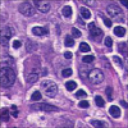

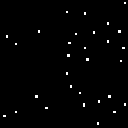

In [ ]:
ix = random.randint(0, len(X_ids))
print(X_ids[ix])
display(Image.fromarray(X[ix]))
display(Image.fromarray(np.squeeze(Y[ix])))

In [ ]:
X_train=X[:95]
Y_train=Y[:95]
X_test=X[95:]
Y_test=Y[95:]

In [ ]:
from keras import backend as K
def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

In [ ]:
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)


c1 = Conv2D(16, (3, 3), activation='relu', padding='same') (s)
#c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2),strides=2) (c1)

c2 = Conv2D(32, (3, 3), activation='relu', padding='same') (p1)
#c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2),strides=2) (c2)

c3 = Conv2D(64, (3, 3), activation='relu', padding='same') (p2)
#c3 = Dropout(0.1) (c3)
c3 = Conv2D(64, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2),strides=2) (c3)

c4 = Conv2D(128, (3, 3), activation='relu', padding='same') (p3)
#c4 = Dropout(0.1) (c4)
c4 = Conv2D(128, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2),strides=2) (c4)

c5 = Conv2D(256, (3, 3), activation='relu', padding='same') (p4)
#c5 = Dropout(0.1) (c5)
c5 = Conv2D(256, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='relu', padding='same') (u6)
#c6 = Dropout(0.1) (c6)
c6 = Conv2D(128, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='relu', padding='same') (u7)
#c7 = Dropout(0.1) (c7)
c7 = Conv2D(64, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='relu', padding='same') (u8)
#c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='relu', padding='same') (u9)
#c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[iou_coef])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 2320        conv2d[0][0]                     
______________________________________________________________________________________________

In [ ]:
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('lymphocytes_counting.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train,validation_data=(X_test,Y_test),batch_size=1, epochs=50,callbacks=[earlystopper, checkpointer])

Epoch 1/50
95/95 [==============================] - 21s 201ms/step - loss: 0.1919 - iou_coef: 0.0174 - val_loss: 0.0213 - val_iou_coef: 0.1086

Epoch 00001: val_loss improved from inf to 0.02132, saving model to lymphocytes_counting.h5
Epoch 2/50
95/95 [==============================] - 18s 189ms/step - loss: 0.0352 - iou_coef: 0.1104 - val_loss: 0.0187 - val_iou_coef: 0.1679

Epoch 00002: val_loss improved from 0.02132 to 0.01875, saving model to lymphocytes_counting.h5
Epoch 3/50
95/95 [==============================] - 18s 190ms/step - loss: 0.0317 - iou_coef: 0.1623 - val_loss: 0.0162 - val_iou_coef: 0.2321

Epoch 00003: val_loss improved from 0.01875 to 0.01623, saving model to lymphocytes_counting.h5
Epoch 4/50
95/95 [==============================] - 18s 190ms/step - loss: 0.0281 - iou_coef: 0.2094 - val_loss: 0.0166 - val_iou_coef: 0.2366

Epoch 00004: val_loss did not improve from 0.01623
Epoch 5/50
95/95 [==============================] - 18s 188ms/step - loss: 0.0282 - iou_c

1/1 [==============================] - 0s 289ms/step
image


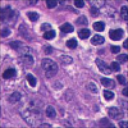



actual mask


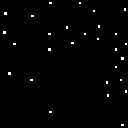



predicted mask


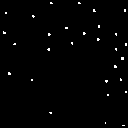

In [ ]:
img_pred = np.expand_dims(X_train[79], axis=0)
pred=model.predict(img_pred, verbose=1)
img=(cv2.cvtColor(np.squeeze((np.round(pred))*255), cv2.COLOR_GRAY2BGR)).astype(np.uint8)
print("image")
display(Image.fromarray(X_train[79]))
print("\n")
print("actual mask")
display(Image.fromarray(np.squeeze(Y_train[79])))
print("\n")
print("predicted mask")
display(Image.fromarray(img))
img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

In [ ]:
model.save("lym_model.h5")

In [ ]:
from google.colab import files
files.download('lym_model.h5') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
contours, hierarchy = cv2.findContours(img,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

In [ ]:
print("Total number of lymphocytes in patch:")
print(len(contours))

Total number of lymphocytes in patch:
29


In [ ]:
img=cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)

In [ ]:
img = cv2.drawContours(img, contours, -1, (0,255,0), 3)

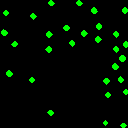

In [ ]:
display(Image.fromarray(img))

In [ ]:
print("lymphocyte coordinates:")
for cnt in contours:
  (x,y),radius = cv2.minEnclosingCircle(cnt)
  print("("+str(x)+","+str(y)+")")

lymphocyte coordinates:
(123.0,125.0)
(105.0,122.5)
(50.0,112.5)
(107.5,94.5)
(125.5,91.5)
(106.0,80.75)
(31.5,79.5)
(120.5,79.0)
(9.0,73.0)
(115.0,66.0)
(122.0,58.0)
(115.5,49.0)
(48.25,49.0)
(125.5,44.0)
(14.0,43.5)
(71.5,43.0)
(97.75,39.0)
(115.5,34.0)
(48.75,34.0)
(83.75,33.0)
(4.0,32.0)
(66.0,27.5)
(98.5,26.0)
(32.83333206176758,15.833333015441895)
(5.5,12.5)
(124.5,10.0)
(94.0,10.0)
(79.0,2.5)
(51.0,2.5)
